### Testing Neural Network based Anomaly Detection on actual data

  This code reads PerfSONAR measured packet loss rates between a specified endpoint and all other endpoints in a selected time range. It tries to train neural network to distinguish measurements belonging to the timebin under investigation from measurements in a reference time period.

In [1]:
%matplotlib inline
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan

from time import time

import numpy as np
import pandas as pd
import random

import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)  
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

from pandas.tseries.offsets import *

Using TensorFlow backend.


#### parameters to set

In [2]:
n_series = 20 

start_date = '2017-05-13 00:00:00'
end_date = '2017-05-16 23:59:59'

# tuning parameters
ref = 24
sub = 1
chance = ref/(sub+ref)
cut = 0.97
print('chance:',chance, '\tcut:', cut)
ref = ref * Hour()
sub = sub * Hour()


srcSiteOWDServer = "128.142.223.247" # CERN site

# destSiteOWDServer = "193.109.172.188"  # pic site

chance: 0.96 	cut: 0.97


## get data from ES

we connect to elasticsearch, create query and execute scan. Query requires three things: data must be in the given timerange, must be measured by the selected endpoint and be packet loss data. Actual data access does not happen here but in the next cell.

In [3]:
es = Elasticsearch(['atlas-kibana.mwt2.org:9200'],timeout=60)
indices = "network_weather-2017.*"

start = pd.Timestamp(start_date)
end   = pd.Timestamp(end_date)

my_query = {
    'query': { 
       'bool':{
            'must':[
                    {'range': {'timestamp': {'gte': start.strftime('%Y%m%dT%H%M00Z'), 'lt': end.strftime('%Y%m%dT%H%M00Z')}}},
                    {'term': {'src': srcSiteOWDServer}},
#                     {'term': {'dest': destSiteOWDServer}},
                    {'term': {'_type': 'packet_loss_rate'}}
                    ]
               }
        }
}


scroll = scan(client=es, index=indices, query=my_query)

### Loading the data

This is the slowest part. It reads ~5k documents per second and will load 1M documents. Expect wait time of ~1 minutes. Actual time might vary depending on your connection and how busy is the Elasticsearch cluster. 

In [4]:
count = 0
allData={} # will be like this: {'dest_host':[[timestamp],[value]], ...} 
for res in scroll:
#     if count<2: print(res) 
    if not count%100000: print(count)
 #   if count>1000000: break
    dst = res['_source']['dest'] # old data - dest, new data - dest_host
    if dst not in allData: allData[dst]=[[],[]]
    allData[dst][0].append(res['_source']['timestamp'] )
    allData[dst][1].append(res['_source']['packet_loss'])
    
    count=count+1

dfs=[]
for dest,data in allData.items():
    ts=pd.to_datetime(data[0],unit='ms')
    df=pd.DataFrame({dest:data[1]}, index=ts )
    df.sort_index(inplace=True)
    df.index = df.index.map(lambda t: t.replace(second=0))
    df = df[~df.index.duplicated(keep='last')]
    dfs.append(df)
    #print(df.head(2))

print(count, "\nData loaded.")

0
100000
200000
300000
400000
495399 
Data loaded.


In [5]:
full_df = pd.concat(dfs, axis=1)

#### Puts together data from different links.

In [6]:
print(full_df.shape)
full_df.head()
#print(full_df.columns )

(5759, 73)


,134.158.159.85,130.209.239.124,192.41.230.59,109.105.125.232,152.84.101.141,129.107.255.29,159.93.225.211,195.194.105.178,144.206.237.142,131.225.2.47,...,165.91.55.4,129.15.40.231,138.253.60.82,149.165.225.223,194.80.35.169,169.228.130.40,81.180.86.38,194.85.69.75,212.193.96.29,148.187.64.25
2017-05-13 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-05-13 00:01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-05-13 00:02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2017-05-13 00:03:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-05-13 00:04:00,0.0,0.0,0.0,0.0,0.0,0.0,0.001667,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### preselecting X worst links but not really the worst

In [7]:
del full_df['134.158.73.243']
means=full_df.mean()
means.sort_values(ascending=False, inplace=True)
means=means[:n_series]
print(means)
df = full_df[means.index.tolist()]
df.shape

158.195.14.26      0.005346
192.54.207.250     0.002886
146.83.90.7        0.002350
130.209.239.124    0.001985
129.93.183.249     0.001601
129.107.255.29     0.001503
193.206.93.45      0.001437
193.239.180.211    0.001325
192.41.230.59      0.001127
131.169.98.30      0.000601
85.122.31.74       0.000589
159.93.225.211     0.000511
134.75.125.241     0.000465
192.231.127.41     0.000445
193.144.80.12      0.000396
159.93.229.151     0.000358
206.12.154.60      0.000331
206.12.9.2         0.000326
109.105.125.232    0.000316
200.136.80.20      0.000304
dtype: float64


(5759, 20)

#### plot timeseries

only a subset of all the links will be shown

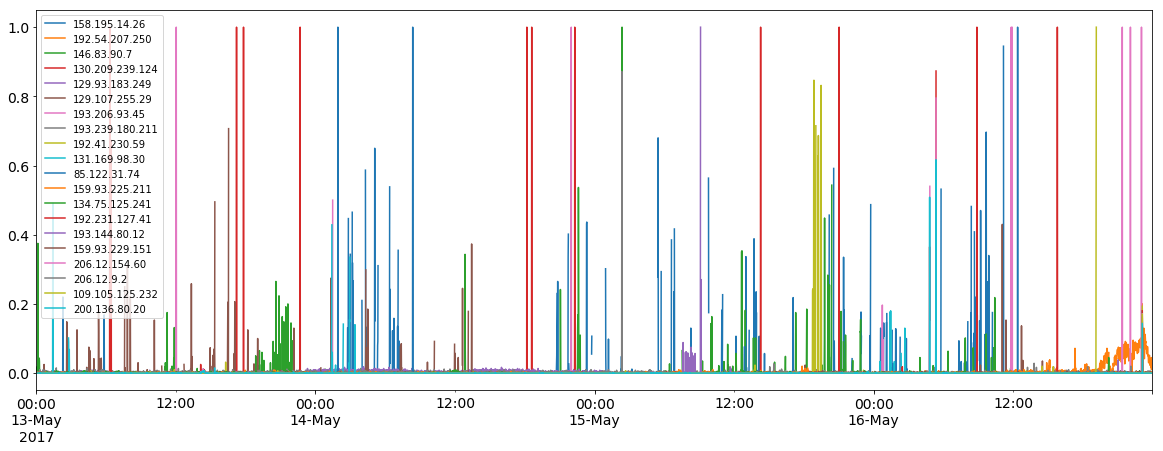

In [8]:
df.plot(figsize=(20,7))

### fix NANs and add accuracy column

In [9]:
# full_df.interpolate(method='nearest', axis=0, inplace=True)
df=df.fillna(0)
auc_df = pd.DataFrame(np.nan, index=df.index, columns=['accuracy'])

### create Network Model

only class is defined, no output is expected.

In [10]:
class ANN(object):
    def __init__(self, n_series):
        self.n_series = n_series
        self.df = None
        self.auc_df = None
        
        self.nn = Sequential()
        self.nn.add(Dense(units=n_series*2, input_shape=(n_series,), activation='relu' ))
#       self.nn.add(Dropout(0.5))
        self.nn.add(Dense(units=n_series*2, activation='relu'))
#       self.nn.add(Dropout(0.5))
        self.nn.add(Dense(units=1, activation='sigmoid'))
#       self.nn.compile(loss='hinge', optimizer='sgd', metrics=['binary_accuracy'])
#       self.nn.compile(loss='mse',optimizer='rmsprop', metrics=['accuracy'])
        self.nn.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy','binary_accuracy' ])
#         self.nn.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy','binary_accuracy' ])
#       self.nn.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['binary_accuracy'])
        self.nn.summary()
        
        self.initial_weights = self.nn.get_weights() 
    
    def set_data(self, df, auc_df):
        self.df = df
        self.auc_df = auc_df
    
    def plot_hist(self, hist):
        es=len(hist.history['loss'])
        x = np.linspace(0,es-1,es)
        plt.plot(x, hist.history['loss'], '--', linewidth=2, label='loss')
        plt.plot(x, hist.history['acc'], '-', linewidth=2, label='acc')
        plt.legend()
        plt.show()
    
    def check_for_anomaly(self,ref, sub, count):
    
        y_ref = pd.Series([0] * ref.shape[0])
        X_ref = ref
    
        y_sub = pd.Series([1] * sub.shape[0])
        X_sub = sub
        
        # separate Reference and Subject into Train and Test
        X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size=0.3)#, random_state=42)
        X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.3)#, random_state=42)
    
        # combine training ref and sub samples
        X_train = pd.concat([X_ref_train, X_sub_train])
        y_train = pd.concat([y_ref_train, y_sub_train])

        # combine testing ref and sub samples
        X_test = pd.concat([X_ref_test, X_sub_test])
        y_test = pd.concat([y_ref_test, y_sub_test])
    
        X_train = X_train.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)
    
        X_train_s, y_train_s = shuffle(X_train, y_train)
    
        self.nn.set_weights(self.initial_weights)
    
        hist = self.nn.fit(X_train_s.values, y_train_s.values, epochs=500, verbose=0, shuffle=True)#, batch_size=10)
        loss_and_metrics = self.nn.evaluate(X_test.values, y_test.values)#, batch_size=256)
        print(loss_and_metrics)
    
        if loss_and_metrics[1] > cut or not count%5: 
            self.plot_hist(hist)
        
        return scaled_accuracy(loss_and_metrics[1], ref.shape[0], sub.shape[0])
    
    
    def loop_over_intervals(self):
        lstart = self.df.index.min()
        lend = self.df.index.max()

        #round start 
        lstart.seconds=0
        lstart.minutes=0

        # loop over them
        ti = lstart + ref + sub
        count = 0
        while ti < lend + 1 * Minute():
            print(count)
            startt = time()
            ref_start = ti-ref-sub
            ref_end = ti-sub
            ref_df = self.df[(self.df.index >= ref_start) & (self.df.index < ref_end)]
            sub_df = self.df[(self.df.index >= ref_end) & (self.df.index < ti)]
#             print('ref:',ref_df.head())
#             print("sub:",sub_df.head())
            accuracy = self.check_for_anomaly(ref_df, sub_df, count)
            self.auc_df.loc[(self.auc_df.index >= ref_end) & (self.auc_df.index < ti), ['accuracy']]  = accuracy
            print('\n',ti,"\trefes:" , ref_df.shape, "\tsubjects:", sub_df.shape, '\tacc:', accuracy)
            ti = ti + sub
            print("took:", time()-startt)
            count = count + 1
            #if count>2: break    

#### functions

In [11]:
def scaled_accuracy(accuracy, ref_samples, sub_samples):
    print(accuracy)
    chance = float(ref_samples)/(ref_samples+sub_samples)
    return (accuracy-chance)/(1-chance)


### Actually create the object, give it a data, run anomally detection. 
This part can take significant time. It takes 10-30 seconds per hour of data analyzed. Total number of steps will be equal to number of subject intervals in the period tested. For every 5th step and  intervals where anomaly has been detected ROC curve will be shown. 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 41        
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________
0
 32/450 [=>............................] - ETA: 0s[0.094018965694639411, 0.95999999999999996, 0.95999999999999996]


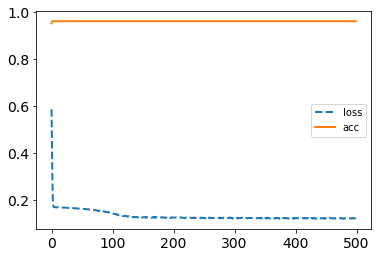

0.96

 2017-05-14 01:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 66.78184461593628
1
 32/450 [=>............................] - ETA: 0s[0.1282338755660587, 0.9622222222222222, 0.9622222222222222]
0.962222222222

 2017-05-14 02:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0555555555556
took: 66.68301010131836
2
 32/450 [=>............................] - ETA: 0s[0.1148516481452518, 0.94888888888888889, 0.94888888888888889]
0.948888888889

 2017-05-14 03:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: -0.277777777778
took: 66.71582460403442
3
 32/450 [=>............................] - ETA: 0s[0.10302394555674659, 0.9622222222222222, 0.9622222222222222]
0.962222222222

 2017-05-14 04:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0555555555556
took: 66.08871650695801
4
 32/450 [=>............................] - ETA: 0s[0.13178024503919814, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-14 05:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0


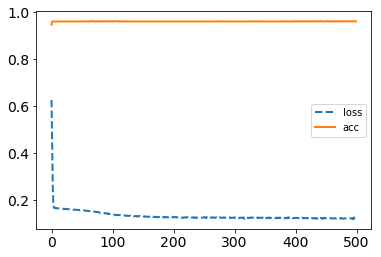

0.957777777778

 2017-05-14 06:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: -0.0555555555556
took: 58.910553216934204
6
 32/450 [=>............................] - ETA: 0s[0.17070173541704814, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-14 07:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 62.67856478691101
7
 32/450 [=>............................] - ETA: 0s[0.14499483055538601, 0.95777777777777773, 0.95777777777777773]
0.957777777778

 2017-05-14 08:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: -0.0555555555556
took: 64.4970543384552
8
 32/450 [=>............................] - ETA: 0s[0.18788727018568252, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-14 09:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 65.30761241912842
9
 32/450 [=>............................] - ETA: 0s[0.19387769248750475, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-14 10:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 66.02702

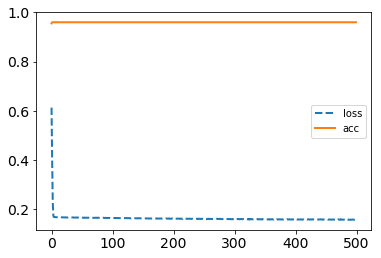

0.96

 2017-05-14 11:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 65.40464234352112
11
 32/450 [=>............................] - ETA: 0s[0.15054813040627374, 0.9622222222222222, 0.9622222222222222]
0.962222222222

 2017-05-14 12:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0555555555556
took: 65.05784177780151
12
 32/450 [=>............................] - ETA: 0s[0.15436642289161681, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-14 13:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 66.20153951644897
13
 32/450 [=>............................] - ETA: 0s[0.14721167445182801, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-14 14:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 65.41656541824341
14
 32/450 [=>............................] - ETA: 0s[0.15833673530154757, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-14 15:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 64.80549383163452
15
 32/450 [

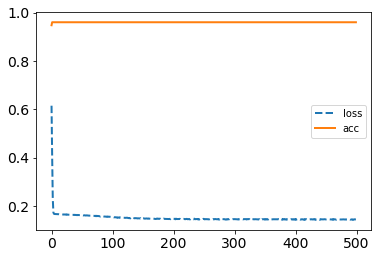

0.96

 2017-05-14 16:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 65.72443890571594
16
 32/450 [=>............................] - ETA: 0s[0.16690477887789409, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-14 17:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 65.58066391944885
17
 32/450 [=>............................] - ETA: 0s[0.17700259897443985, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-14 18:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 64.67948126792908
18
 32/450 [=>............................] - ETA: 0s[0.19361003239949545, 0.95777777777777773, 0.95777777777777773]
0.957777777778

 2017-05-14 19:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: -0.0555555555556
took: 63.3278534412384
19
 32/450 [=>............................] - ETA: 0s[0.17621282445059883, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-14 20:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 65.44650721549988
20
 32/450

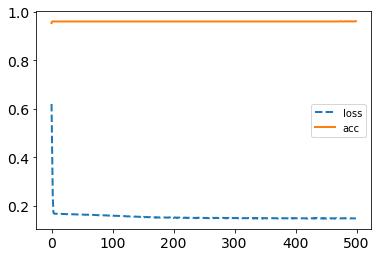

0.96

 2017-05-14 21:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 65.54033756256104
21
 32/450 [=>............................] - ETA: 0s[0.2262302753660414, 0.95777777777777773, 0.95777777777777773]
0.957777777778

 2017-05-14 22:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: -0.0555555555556
took: 65.31617975234985
22
 32/450 [=>............................] - ETA: 0s[0.17565327021810745, 0.9555555555555556, 0.9555555555555556]
0.955555555556

 2017-05-14 23:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: -0.111111111111
took: 64.85337233543396
23
 32/450 [=>............................] - ETA: 0s[0.15096904304292466, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-15 00:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 65.42006850242615
24
 32/450 [=>............................] - ETA: 0s[0.16381651322046917, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-15 01:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 64.21922

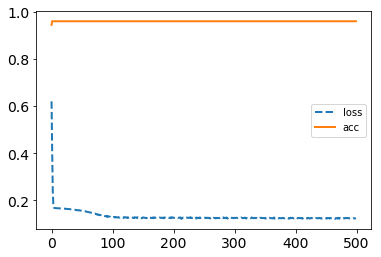

0.96

 2017-05-15 02:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 65.60212087631226
26
 32/450 [=>............................] - ETA: 0s[0.13627561224831475, 0.95777777777777773, 0.95777777777777773]
0.957777777778

 2017-05-15 03:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: -0.0555555555556
took: 65.04938387870789
27
 32/450 [=>............................] - ETA: 0s[0.13197690924008687, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-15 04:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 65.1018316745758
28
 32/450 [=>............................] - ETA: 0s[0.16250158707300821, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-15 05:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 65.80751538276672
29
 32/450 [=>............................] - ETA: 0s[0.15920535508129333, 0.95777777777777773, 0.95777777777777773]
0.957777777778

 2017-05-15 06:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: -0.0555555555556
took: 65.46

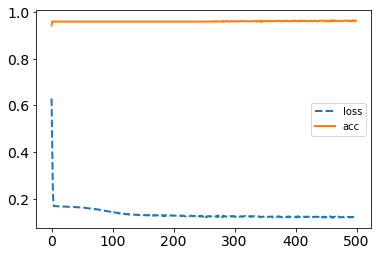

0.968888888889

 2017-05-15 07:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.222222222222
took: 65.78986716270447
31
 32/450 [=>............................] - ETA: 0s[0.13989615016513401, 0.9622222222222222, 0.9622222222222222]
0.962222222222

 2017-05-15 08:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0555555555556
took: 64.77211928367615
32
 32/450 [=>............................] - ETA: 0s[0.11666196942329407, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-15 09:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 64.85517191886902
33
 32/450 [=>............................] - ETA: 0s[0.095028183327780832, 0.97555555555555551, 0.97555555555555551]


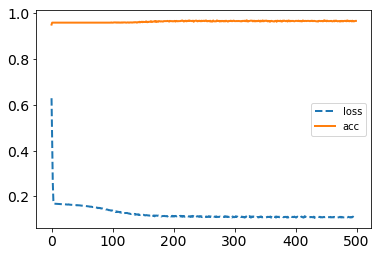

0.975555555556

 2017-05-15 10:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.388888888889
took: 56.70660448074341
34
 32/450 [=>............................] - ETA: 0s[0.1412559852997462, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-15 11:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 58.91021728515625
35
 32/450 [=>............................] - ETA: 0s[0.15349846760431926, 0.95999999999999996, 0.95999999999999996]


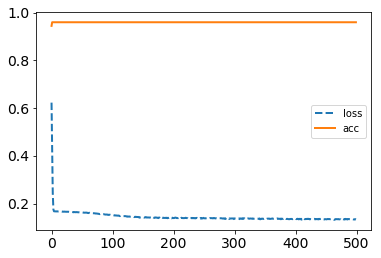

0.96

 2017-05-15 12:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 60.60955786705017
36
 32/450 [=>............................] - ETA: 0s[0.19050115095244513, 0.95111111111111113, 0.95111111111111113]
0.951111111111

 2017-05-15 13:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: -0.222222222222
took: 58.88368368148804
37
 32/450 [=>............................] - ETA: 0s[0.14664829366736942, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-15 14:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 59.37730932235718
38
 32/450 [=>............................] - ETA: 0s[0.16377471089363099, 0.95333333333333337, 0.95333333333333337]
0.953333333333

 2017-05-15 15:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: -0.166666666667
took: 59.82905721664429
39
 32/450 [=>............................] - ETA: 0s[0.19266950792736479, 0.95777777777777773, 0.95777777777777773]
0.957777777778

 2017-05-15 16:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: -0.055

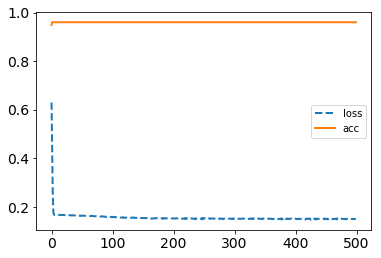

0.96

 2017-05-15 17:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 66.35785031318665
41
 32/450 [=>............................] - ETA: 0s[0.18090699646208022, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-15 18:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 66.92050671577454
42
 32/450 [=>............................] - ETA: 0s[0.10864825805028279, 0.96888888888888891, 0.96888888888888891]
0.968888888889

 2017-05-15 19:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.222222222222
took: 66.12164688110352
43
 32/450 [=>............................] - ETA: 0s[0.18894878678851657, 0.9622222222222222, 0.9622222222222222]
0.962222222222

 2017-05-15 20:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0555555555556
took: 66.17132830619812
44
 32/450 [=>............................] - ETA: 0s[0.17131096164385479, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-15 21:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 65.332907

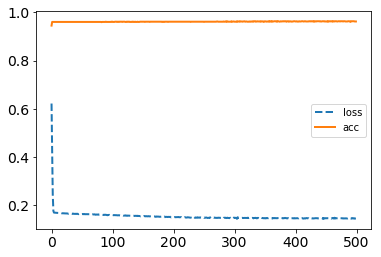

0.955555555556

 2017-05-15 22:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: -0.111111111111
took: 65.70823216438293
46
 32/450 [=>............................] - ETA: 0s[0.17240803930494519, 0.95777777777777773, 0.95777777777777773]
0.957777777778

 2017-05-15 23:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: -0.0555555555556
took: 65.79303169250488
47
 32/450 [=>............................] - ETA: 0s[0.15812295887205335, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-16 00:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 65.45864605903625
48
 32/450 [=>............................] - ETA: 0s[0.18688494894239638, 0.9622222222222222, 0.9622222222222222]
0.962222222222

 2017-05-16 01:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0555555555556
took: 64.82577967643738
49
 32/450 [=>............................] - ETA: 0s[0.17483057419459025, 0.9622222222222222, 0.9622222222222222]
0.962222222222

 2017-05-16 02:00:00 	refes: (1440, 20) 	subjects: (6

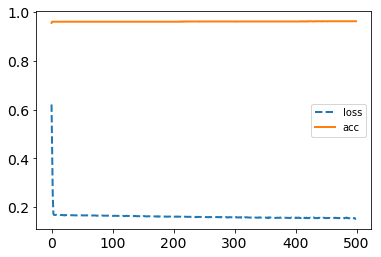

0.955555555556

 2017-05-16 03:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: -0.111111111111
took: 64.00099921226501
51
 32/450 [=>............................] - ETA: 0s[0.20073537442419265, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-16 04:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 64.02989029884338
52
 32/450 [=>............................] - ETA: 0s[0.15693593555026583, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-16 05:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 65.20522546768188
53
 32/450 [=>............................] - ETA: 0s[0.21608188311258952, 0.95777777777777773, 0.95777777777777773]
0.957777777778

 2017-05-16 06:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: -0.0555555555556
took: 65.86311316490173
54
 32/450 [=>............................] - ETA: 0s[0.15883053594165378, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-16 07:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 64.21

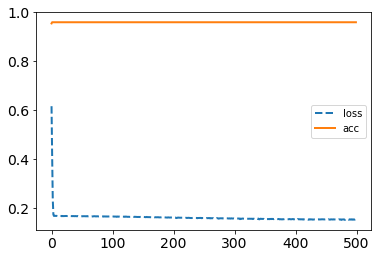

0.96

 2017-05-16 08:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 58.816548109054565
56
 32/450 [=>............................] - ETA: 0s[0.22977445602416993, 0.9555555555555556, 0.9555555555555556]
0.955555555556

 2017-05-16 09:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: -0.111111111111
took: 58.995017528533936
57
 32/450 [=>............................] - ETA: 0s[0.24797227938969929, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-16 10:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 63.97779130935669
58
 32/450 [=>............................] - ETA: 0s[0.16485679970847236, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-16 11:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 66.29075908660889
59
 32/450 [=>............................] - ETA: 0s[0.1467227159606086, 0.96444444444444444, 0.96444444444444444]
0.964444444444

 2017-05-16 12:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.111111111111
took: 65.30733

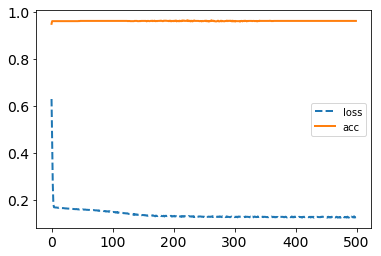

0.96

 2017-05-16 13:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 64.51691770553589
61
 32/450 [=>............................] - ETA: 0s[0.11971497350268893, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-16 14:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 59.98486876487732
62
 32/450 [=>............................] - ETA: 0s[0.19383503430419499, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-16 15:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 60.5387442111969
63
 32/450 [=>............................] - ETA: 0s[0.17688361797067853, 0.96888888888888891, 0.96888888888888891]
0.968888888889

 2017-05-16 16:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.222222222222
took: 59.73986005783081
64
 32/450 [=>............................] - ETA: 0s[0.12977875947952269, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-16 17:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 58.84806227684021
65
 32/450 [

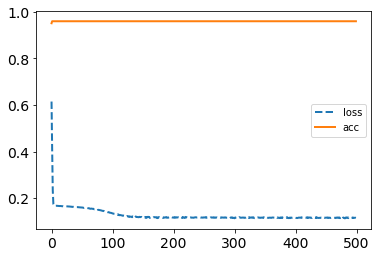

0.96

 2017-05-16 18:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 61.0897479057312
66
 32/450 [=>............................] - ETA: 0s[0.10024103813701206, 0.95999999999999996, 0.95999999999999996]
0.96

 2017-05-16 19:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 65.96490430831909
67
 32/450 [=>............................] - ETA: 0s[0.18119455673628382, 0.96666666666666667, 0.96666666666666667]
0.966666666667

 2017-05-16 20:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.166666666667
took: 66.68678283691406
68
 32/450 [=>............................] - ETA: 0s[0.13799654040071699, 0.95777777777777773, 0.95777777777777773]
0.957777777778

 2017-05-16 21:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: -0.0555555555556
took: 66.23415899276733
69
 32/450 [=>............................] - ETA: 0s[0.082421531656032637, 0.97777777777777775, 0.97777777777777775]


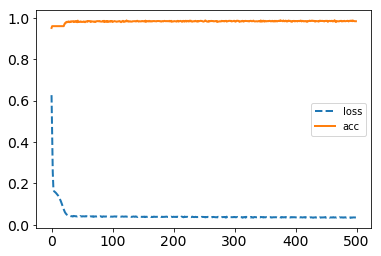

0.977777777778

 2017-05-16 22:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.444444444444
took: 64.98149919509888
70
 32/450 [=>............................] - ETA: 0s[0.069576706588268283, 0.97111111111111115, 0.97111111111111115]


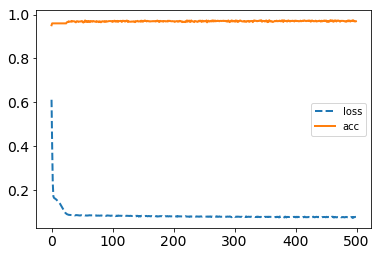

0.971111111111

 2017-05-16 23:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.277777777778
took: 66.5430235862732


In [12]:
ann = ANN(n_series)
ann.set_data(df, auc_df)
ann.loop_over_intervals()

### plot again full timeseries

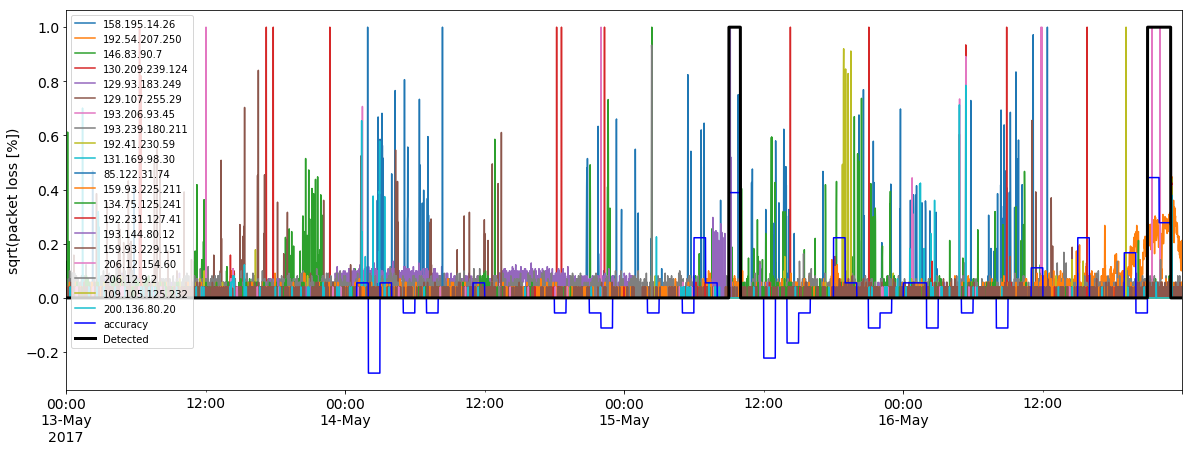

In [21]:
ndf=df.applymap(np.sqrt)
ax = ndf.plot(figsize=(20,7))
ax.set_xlim([pd.to_datetime('2017-05-13'),pd.to_datetime('2017-05-17')])
auc_df['Detected'] = 0
auc_df.loc[auc_df.accuracy>0.25, ['Detected']]=1
auc_df.accuracy.plot( ax=ax,color='b')
auc_df.Detected.plot( ax=ax, color='black', lw=3)
ax.legend(loc='upper left')
ax.set_ylabel("sqrt(packet loss [%])", fontsize=14)
plt.show()
ax.get_figure().savefig('ANN_actual_data.png')

### shade regions where an anomaly has been dected

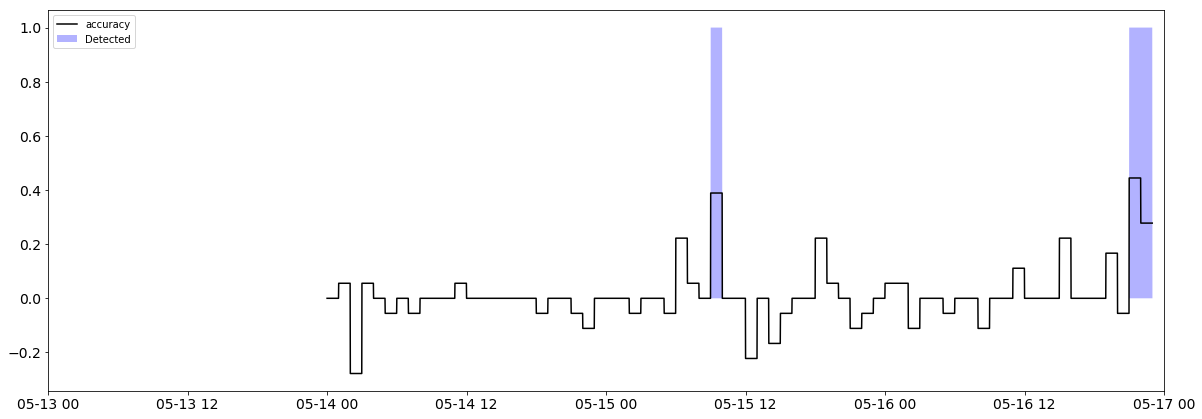

In [16]:
fig, ax = plt.subplots(figsize=(20,7))
auc_df['Detected'] = 0
auc_df.loc[auc_df.accuracy>0.25, ['Detected']]=1
ax.plot( auc_df.accuracy,'black')
ax.fill( auc_df.Detected, 'b', alpha=0.3)
ax.legend(loc='upper left')
ax.set_xlim([pd.to_datetime('2017-05-13'),pd.to_datetime('2017-05-17')])
plt.show()
fig.savefig('ANN_shaded_actual_data.png')
